## Complex MatMul problem, two ways

Let's first define the forward problem

$$
y = Ax
$$

where x is real, A is complex and y is complex. With an abuse of notation we can write

$$
y_r + jy_i = A_r * x + j(A_i * x)
$$

We can now just solve the first problem

$$
x = A^{-1} y
$$

or divide it into two set of equations, one for real and one for complex (after all x is real so there is no 'cross-talk':

$$
A_1 = [A_r, A_i]^T \quad y_1 = [y_r, y_i]^T \quad 
$$

and then write

$$
x = A_1^{-1} y_1
$$

This proves the two solutions are identical. We will also verify it numerically.

Finally note that if we write the normal equations we have

$$
x = (A_r^TA_r + A_i^TA_i)^{-1} (A_r^Ty_r + A_i^Ty_i)
$$

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.sparse.linalg import LinearOperator as spLinearOperator
from pylops.basicoperators import *
from pylops.utils import dottest
from pylops.optimization.basic import cgls

from pylops import LinearOperator, MatrixMult, MemoizeOperator

In [2]:
n = 100

x = np.arange(n) + 1.

# make A
Ar = np.random.normal(0, 1, (n, n))
Ai = np.random.normal(0, 1, (n, n))
A = Ar + 1j * Ai

Aop = MatrixMult(A)

# make y first eq
y = Aop @ x

# make y second eq
y_ = MatrixMult(Ar) @ x + 1j * MatrixMult(Ai) @ x

np.allclose(y, y_)

True

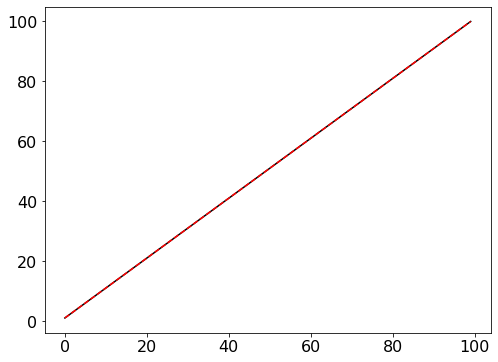

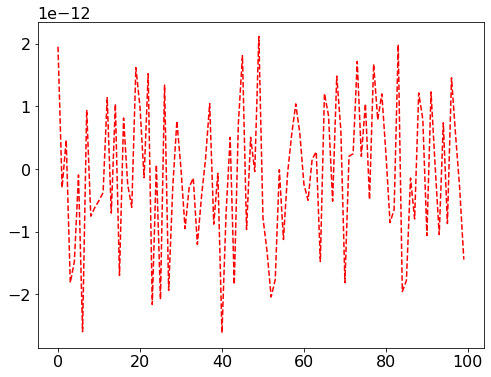

In [3]:
# invert x third eq
xinv = Aop.div(y)

plt.figure()
plt.plot(x, 'k')
plt.plot(np.real(xinv), '--r')

plt.figure()
plt.plot(np.imag(xinv), '--r');

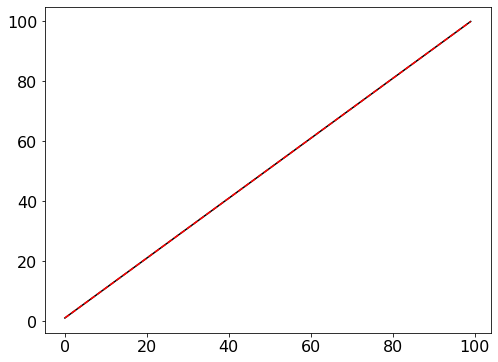

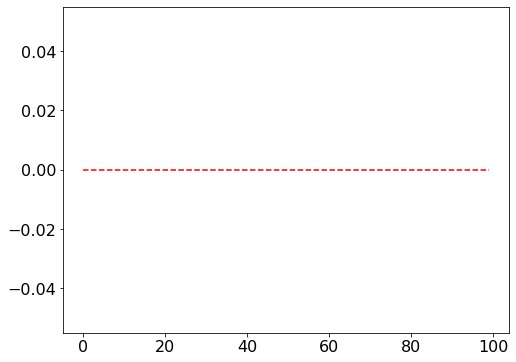

In [4]:
# invert x 4-5 eqs
y1 = np.concatenate([np.real(y), np.imag(y)])
A1op = VStack([MatrixMult(np.real(A)), MatrixMult(np.imag(A))])

xinv1 = A1op.div(y1)

plt.figure()
plt.plot(x, 'k')
plt.plot(np.real(xinv1), '--r')

plt.figure()
plt.plot(np.imag(xinv1), '--r');

So far so good, even when using PyLops.. but we have cheated as we have a dense matrix and can take its real and imag parts and write eq 4-5.

But what about if we dont know the entries of the matrix/operator... we only know that it takes a real number and produces a complex (whilst its adjoint takes a complex and produces a real.

First we do something similar to eq3 and use the fact we can manipulate the adjoint to make it real.

In [5]:
class MatMult_cmpx(LinearOperator):
    def __init__(self, A, dtype='float64'):
        self.A = A
        self.shape = A.shape
        self.dtype = np.dtype(dtype)
        self.explicit = False
        self.matvec_count = 0.
        self.rmatvec_count = 0.
        
    def _matvec(self, x):
        y = A @ x
        return y

    def _rmatvec(self, x):
        y = np.real(np.conj(A.T) @ x)
        return y

In [6]:
Aop = MatMult_cmpx(A)
for complexflag in range(4):
    if complexflag == 0:
        print("Both model and data are real    :", end=' ')
    elif complexflag == 1:
        print("Only data is real               :", end=' ')
    elif complexflag == 2:
        print("Only model is real              :", end=' ')
    elif complexflag == 3:
        print("Neither data nor model are real :", end=' ')
    try:
        dottest(Aop, n, n, complexflag=complexflag)
        print("pass")
    except AssertionError:
        print("fail")

Both model and data are real    : fail
Only data is real               : fail
Only model is real              : fail
Neither data nor model are real : fail


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


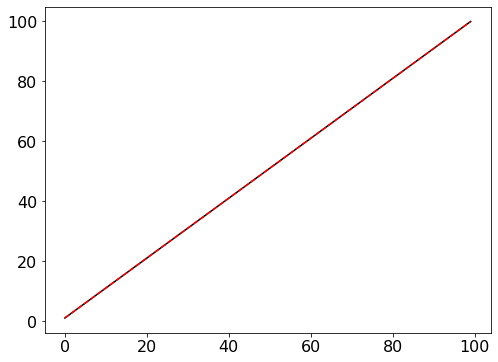

In [7]:
# invert x third eq (with guaranteed 0 imag component)
xinv = Aop.div(y)

plt.figure()
plt.plot(x, 'k')
plt.plot(np.real(xinv), '--r')

print(np.imag(xinv))

[ 1.95432559e-12 -2.95985458e-13  4.65183447e-13 -1.81321624e-12
 -1.46993528e-12 -9.32587341e-14 -2.59481325e-12  9.47242285e-13
 -7.50510765e-13 -6.10178574e-13 -5.01820807e-13 -3.73923115e-13
  1.14042109e-12 -7.00772773e-13  1.04183329e-12 -1.69642078e-12
  8.15347789e-13 -2.44249065e-13 -6.09290396e-13  1.62003744e-12
  9.96536187e-13 -1.36335387e-13  1.52500235e-12 -2.16004992e-12
  6.75015599e-14 -2.07922568e-12  1.34114941e-12 -1.93622895e-12
 -2.82440737e-13  7.68274333e-13  7.10542736e-15 -9.48574552e-13
 -2.91322522e-13 -1.42108547e-13 -1.20081722e-12 -4.44089210e-13
  1.66977543e-13  1.04627418e-12 -8.77520279e-13 -6.75015599e-14
 -2.61479727e-12 -7.10542736e-13  5.08038056e-13 -1.84030569e-12
  7.24753590e-13  1.81188398e-12 -9.64561764e-13  5.08038056e-13
 -3.90798505e-14  2.11741735e-12 -7.74491582e-13 -1.31450406e-12
 -2.03925765e-12 -1.76214598e-12 -1.06581410e-14 -1.12265752e-12
 -7.46069873e-14  5.47117907e-13  1.04094511e-12  5.68434189e-13
 -2.41584530e-13 -4.97379

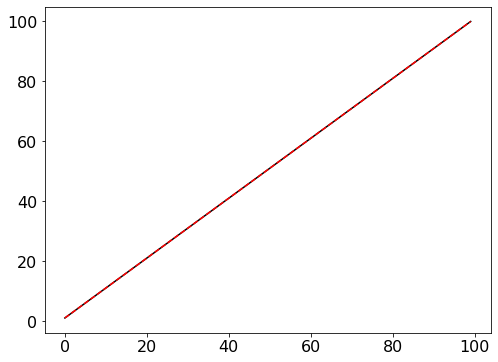

In [8]:
Aop = MatrixMult(A)
Aop = Aop.toreal(forw=False, adj=True)

xinv = Aop.div(y)

plt.figure()
plt.plot(x, 'k')
plt.plot(np.real(xinv), '--r')

print(np.imag(xinv))

Next we try to work with real and imag parts separately as in eq4 and eq5

In [9]:
class MatMult_cmpx(LinearOperator):
    def __init__(self, A, real=True, dtype='float64'):
        self.A = A
        self.shape = A.shape
        self.dtype = np.dtype(dtype)
        self.explicit = False
        
        self.real = real
        self.xprev = None
        self.yprev = None
            
        self.neval = 0 # number of evaluations of the operator
        self.matvec_count = 0.
        self.rmatvec_count = 0.
        
    def _matvec(self, x):
        y = A @ x # forward (can be any!)
        self.neval += 1
        if self.real:
            y = np.real(A @ x)
        else:
            y = np.imag(A @ x)
        return y

    def _rmatvec(self, y):
        x = np.conj(A.T) @ y # adjoint (can be any!)
        self.neval += 1
        if self.real:
            x = np.real(x)
        else:
            # - is require because we want the result of the imag component of A and y, 
            # but since we conjugated
            x = -np.imag(x) 
        return x

In [10]:
Arop = MatMult_cmpx(A, real=True)
Aiop = MatMult_cmpx(A, real=False)

dottest(Arop, n, n, complexflag=0, verb=True)
dottest(Aiop, n, n, complexflag=0, verb=True)

Dot test passed, v^H(Opu)=172.4253202182993 - u^H(Op^Hv)=172.42532021829933
Dot test passed, v^H(Opu)=-96.52291018159103 - u^H(Op^Hv)=-96.52291018159097


True

43 43 86


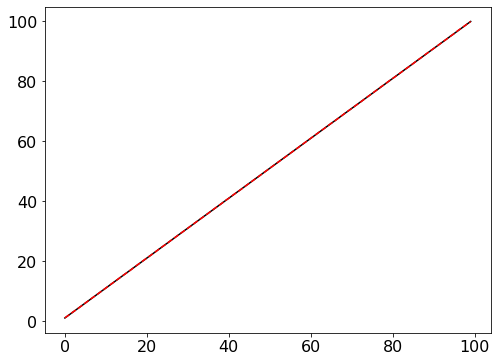

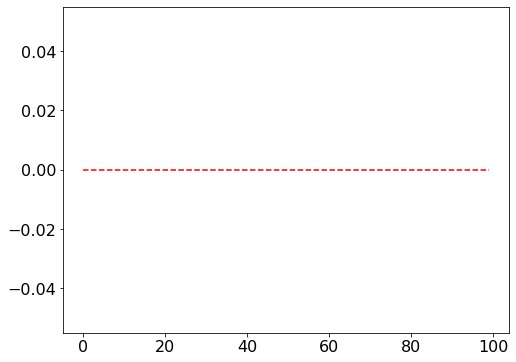

In [11]:
# invert x 4-5 eqs
y1 = np.concatenate([np.real(y), np.imag(y)])

Arop = MatMult_cmpx(A, real=True)
Aiop = MatMult_cmpx(A, real=False)
A1op = VStack([Arop, Aiop])

xinv1 = cgls(A1op, y1, np.zeros(n), niter=20)[0]

plt.figure()
plt.plot(x, 'k')
plt.plot(np.real(xinv1), '--r')

plt.figure()
plt.plot(np.imag(xinv1), '--r')

print(Arop.neval, Aiop.neval, Arop.neval + Aiop.neval)

This is inefficient, at every iteration we need to perform 2 forwards and 2 adoints (one for the real and one for the imag part).

We need something to tell the operator that the operation has been already performed, to simply compute the real or imag part...

In [12]:
Amop = MemoizeOperator(MatrixMult(A))
Arop = Amop.toreal()
Aiop = Amop.toimag()

dottest(Arop, n, n, complexflag=0, verb=True)
dottest(Aiop, n, n, complexflag=0, verb=True)

Dot test passed, v^H(Opu)=149.27238409727804 - u^H(Op^Hv)=149.27238409727798
Dot test passed, v^H(Opu)=-168.86457251544553 - u^H(Op^Hv)=-168.8645725154455


True

In [13]:
# Let's check our counter works
Amop = MemoizeOperator(MatrixMult(A))

Amop * np.ones(n) # 1st
print(Amop.neval)
Amop * np.ones(n) # same
print(Amop.neval)
Amop * np.zeros(n) # new
print(Amop.neval)

Amop.H * np.full(n, 3) # 1st
print(Amop.neval)
Amop.H * np.full(n, 3) # same
print(Amop.neval)
Amop.H * np.full(n, 5) # new
print(Amop.neval)

1
1
2
3
3
4


In [14]:
Amop = MemoizeOperator(MatrixMult(A))
Arop = Amop.toreal()
Aiop = Amop.toimag()

A1op = VStack([Arop, Aiop])

A1op * np.zeros(n) # 1st
print(Amop.neval)
A1op * np.zeros(n) # same
print(Amop.neval)
A1op * np.full(n, 2) # new
print(Amop.neval)

A1op.H * np.ones(2*n) # 1st
print(Amop.neval)
A1op.H * np.ones(2*n) # same
print(Amop.neval)
A1op.H * np.full(2*n, 5) # new
print(Amop.neval)

1
1
2
3
3
4


0
64


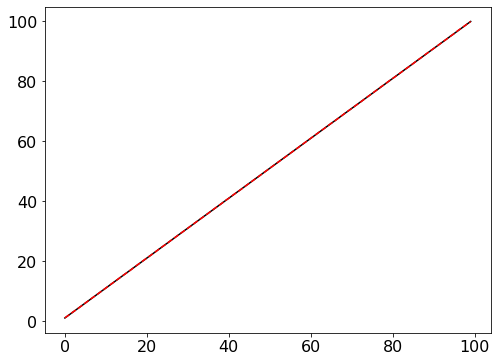

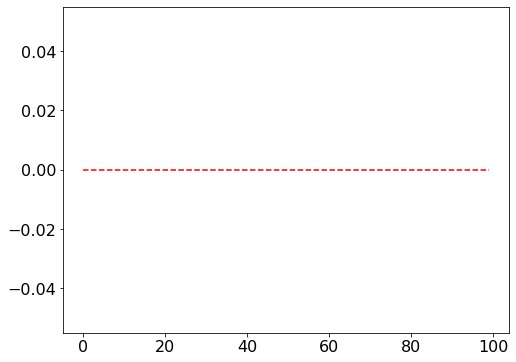

In [15]:
Amop = MemoizeOperator(MatrixMult(A), max_neval=10)
Arop = Amop.toreal()
Aiop = Amop.toimag()

A1op = VStack([Arop, Aiop])
y1 = np.concatenate([np.real(y), np.imag(y)])
print(A1op.ops[0].Op.neval)
#xinv2 = A1op.div(y1)
xinv2 = cgls(A1op, y1, np.zeros(n), niter=20)[0]

plt.figure()
plt.plot(x, 'k')
plt.plot(np.real(xinv2), '--r')

plt.figure()
plt.plot(np.imag(xinv2), '--r')

print(Amop.neval)

Less than before, as we have always 0 for the imag component of our model...

In [16]:
Amem = MemoizeOperator(Aop, max_neval=2)

print(Amem.neval)
Amem * np.ones(n) # 1st
print(Amem.neval)
Amem * np.ones(n) # same
print(Amem.neval)
Amem * np.ones(n) # same
print(Amem.neval)
Amem * (2*np.ones(n)) # new
print(Amem.neval)
Amem * (2*np.ones(n)) # same
print(Amem.neval)
Amem * (3*np.ones(n)) # new, bumped np.ones(n) from memory
print(Amem.neval)
Amem * np.ones(n) # new, bumped 2*np.ones(n) from memory
print(Amem.neval)
Amem * np.ones(n) # same
print(Amem.neval)

0
1
1
1
2
2
3
4
4


## Comparison with Imag, Real, Conj operators

If we want to extract the real part of the output of an operator we must use `Real`.

If we simply want to take the real part of the operator and apply it to a real vector x then we can use `.toreal` (with the flag only on the forward).

Note that the former acts as a R-linear operator so in the adjoint the chain of operations is reversed, while the latter always applies the operator first and the real/imag extraction after so it cannot be expected to pass the dottest. It should therefore only be used in the special case we want to create a complex operator that acts on a real vector x and extracts the real part or imag part of it as in the example above.

In [17]:
n = 4
x = np.arange(n) + 1j * np.arange(n)
y = np.arange(n) + 1j * np.arange(n)

# make A
Ar = np.random.normal(0, 1, (n, n))
Ai = np.random.normal(0, 1, (n, n))
A = Ar + 1j * Ai

In [18]:
Aop = MatrixMult(A)
Rop = Real(n)
Op1 = Rop * Aop
Op2 = Aop.toreal(adj=False)
print(dottest(Op1))

y1 = Op1 * x
y2 = Op2 * x
print(y1, y1 - y2)

xadj1 = Op1.H * y
xadj2 = Op2.H * y
print(xadj1, xadj2, xadj1 - xadj2)

True
[-4.52339621  2.98042928  1.04078149 13.67785147] [0. 0. 0. 0.]
[-1.38196823e+00+7.27367652j  4.24925981e-03+6.16394818j
  7.23821874e+00+4.00170772j  1.81010995e+00+4.00572214j] [-8.65564475 +5.89170828j -6.15969892 +6.16819744j
  3.23651102+11.23992646j -2.19561219 +5.8158321j ] [7.27367652+1.38196823e+00j 6.16394818-4.24925981e-03j
 4.00170772-7.23821874e+00j 4.00572214-1.81010995e+00j]


Same for imag

In [19]:
Aop = MatrixMult(A)
Iop = Imag(n)
Op1 = Iop * Aop
Op2 = Aop.toimag(adj=False)
print(dottest(Op1))

y1 = Op1 * x
y2 = Op2 * x
print(y1, y1 - y2)

xadj1 = Op1.H * y
xadj2 = Op2.H * y
print(xadj1, xadj2, xadj1 - xadj2)

True
[ 0.38423783 -4.24337062 -0.29516118 -0.47994016] [0. 0. 0. 0.]
[-7.27367652-1.38196823e+00j -6.16394818+4.24925981e-03j
 -4.00170772+7.23821874e+00j -4.00572214+1.81010995e+00j] [-8.65564475 +5.89170828j -6.15969892 +6.16819744j
  3.23651102+11.23992646j -2.19561219 +5.8158321j ] [ 1.38196823e+00-7.27367652j -4.24925981e-03-6.16394818j
 -7.23821874e+00-4.00170772j -1.81010995e+00-4.00572214j]


Complex conjugation: here we can use both `.conj` and `Conj` in the same way.

In [22]:
Aop = MatrixMult(A)

Op1 = Aop.conj()
Op2 = Op1.toreal(adj=False)
print(dottest(Op1))

y1 = Op1 * x
y2 = Op2 * x
print(y1, y1 - y2)

xadj1 = Op1.H * y
xadj2 = Op2.H * y
print(xadj1, xadj2, xadj1 - xadj2)

True
[ 0.38423783 -4.52339621j -4.24337062 +2.98042928j
 -0.29516118 +1.04078149j -0.47994016+13.67785147j] [0. -4.52339621j 0. +2.98042928j 0. +1.04078149j 0.+13.67785147j]
[ 5.89170828-8.65564475j  6.16819744-6.15969892j 11.23992646+3.23651102j
  5.8158321 -2.19561219j] [ 5.89170828-8.65564475j  6.16819744-6.15969892j 11.23992646+3.23651102j
  5.8158321 -2.19561219j] [0.+0.j 0.+0.j 0.+0.j 0.+0.j]
